# Training a neural network model to generate a document deformation mesh in an image.

Author: Maciej Kubiś

Date: 2025-03-24

The notebook will allow training of various AI models created using **PyTorch**. Various architectures modeled on **U-Net** will be tested.

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import importlib.util
import sys
import torch.nn.functional as F
from IPython.display import clear_output

sys.path.append("../src") 

spec = importlib.util.spec_from_file_location("data_generator", "../src/data_generator.py")
data_generator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(data_generator)

spec = importlib.util.spec_from_file_location("neuralnet_handler", "../src/neuralnet_handler.py")
neuralnet_handler = importlib.util.module_from_spec(spec)
spec.loader.exec_module(neuralnet_handler)

## Configuration

It is possible to set device where will be handle neural network. Image generator require file with any text to produce random content of documents.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = data_generator.DocumentImageGenerator("../src/assets/text.txt")

nn_handler = neuralnet_handler.NeuralNetHandler(None, generator, device, 3000, 0.01, 20)

Using device: cpu
Model is None. Please provide a valid model using set_model() method.


## U-Net model


The `UNetFlexible` is a custom implementation of the U-Net architecture designed for grid regression (e.g., predicting (x, y) offsets per pixel). It is built to work with **arbitrary input image sizes**, not just those that are powers of 2.

### Architecture Overview

- **Encoder**: 3 convolutional blocks with downsampling (`MaxPool2d`), each doubling the number of channels.
- **Bottleneck**: A deeper feature extractor that expands feature capacity.
- **Decoder**: 3 upsampling blocks using `bilinear interpolation`, followed by `Conv2d` layers and skip connections.
- **Final Output**: A `1x1 Conv2d` layer projecting to 2 channels (for `(x, y)` offset prediction per pixel).

### Skip Connections

The model uses **skip connections** with dynamic interpolation (`F.interpolate`) to **align spatial dimensions** when concatenating encoder and decoder feature maps — this ensures compatibility with **any image size**, including those **not divisible by powers of 2**.

### Output Behavior

- Input shape: `(N, 1, H, W)` — single-channel grayscale images.
- Output shape: `(N, 2, H, W)` — two-channel output with predicted `(x, y)` offsets for each pixel.

### Customization

- `base_channels`: Controls the number of filters in the first encoder block (default = 64).
- Fully convolutional — supports dynamic image sizes at inference without needing resizing to specific dimensions.

In [ ]:
class UNetFlexible(nn.Module):
    def __init__(self, base_channels=64):
        super(UNetFlexible, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(1, base_channels)
        self.enc2 = self.conv_block(base_channels, base_channels * 2)
        self.enc3 = self.conv_block(base_channels * 2, base_channels * 4)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.conv_block(base_channels * 4, base_channels * 8)

        # Decoder
        self.up3 = self.up_block(base_channels * 8, base_channels * 4)
        self.up2 = self.up_block(base_channels * 4 * 2, base_channels * 2)
        self.up1 = self.up_block(base_channels * 2 * 2, base_channels)

        # Final layer
        self.final_conv = nn.Conv2d(base_channels * 2, 2, kernel_size=1)  # 2 channels for (x, y) offsets

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def up_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.up3(b)
        e3 = F.interpolate(e3, size=d3.shape[2:], mode='bilinear', align_corners=True)
        d3 = torch.cat([d3, e3], dim=1)

        d2 = self.up2(d3)
        e2 = F.interpolate(e2, size=d2.shape[2:], mode='bilinear', align_corners=True)
        d2 = torch.cat([d2, e2], dim=1)

        d1 = self.up1(d2)
        e1 = F.interpolate(e1, size=d1.shape[2:], mode='bilinear', align_corners=True)
        d1 = torch.cat([d1, e1], dim=1)

        out = self.final_conv(d1)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=True)

        return out


model = UNetFlexible()  # You can adjust base_channels as needed
nn_handler.set_model(model, "unet_deform")

#### Function for plotting results:

In [ ]:
def plot():
    # Clear the output before plotting
    clear_output(wait=True)

    # Plot training progress
    plt.figure(figsize=(10, 4))
    plt.plot(nn_handler.get_train_losses(), label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss (U-Net)')
    plt.grid(True)
    plt.legend()
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.show()

    # Plot validation progress
    plt.figure(figsize=(10, 4))
    plt.plot(nn_handler.get_val_losses(), label='Validation Loss', color='green')
    plt.xlabel('Evaluation Steps (every 60 epochs)')
    plt.ylabel('Loss')
    plt.title('Validation Loss (U-Net)')
    plt.grid(True)
    plt.legend()
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.show()

### Training and results

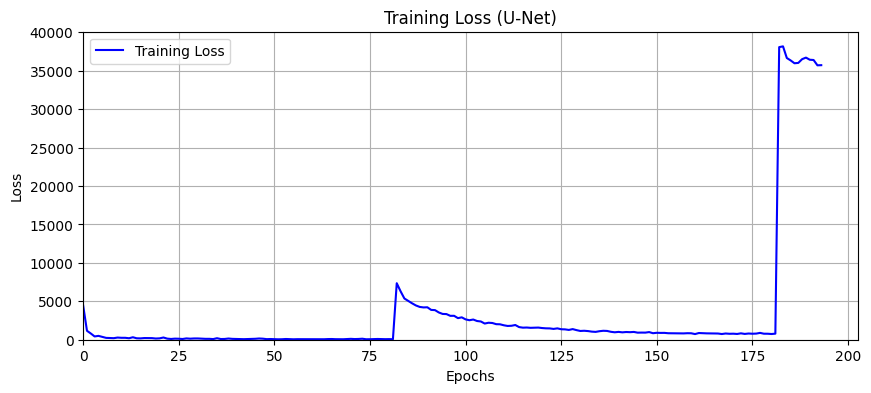

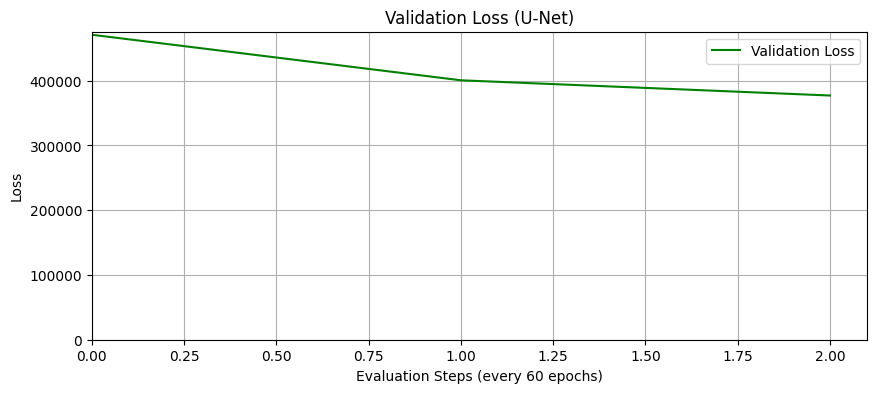

In [6]:
nn_handler.train(resume_from_checkpoint=True)

plot()

#### Ensure model save

In [7]:
nn_handler.save_model("../models/unet_deform.pth")

Model saved to ../models/unet_deform.pth
